**Kaggle**

# Titanic competition for practicing Stacking Ensemble technique

* Written by JEONGWOO JIN(South Korea)
* Pub Date : 2017.10.16

### Content

1. Introduction of 'Machine learning Processe and checking data'

2. EDA on train data

3. Feature extraction

4. Feature selection

5. Base modeling and evaluating among all models

6. Using Stacking ensemble technique

7. Conclusion and report

### 참고 및 인용
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

http://rfriend.tistory.com/tag/%EA%B5%90%EC%B0%A8%ED%91%9C

http://trevorstephens.com/kaggle-titanic-tutorial/r-part-2-the-gender-class-model/

https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

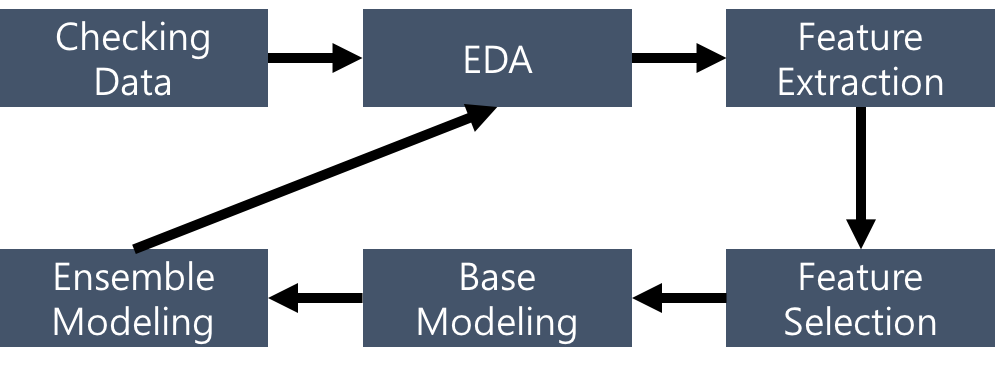

In [142]:
from IPython.display import Image
Image(filename='../img/1-1png.png', width=500, height=500) 

##  EDA on train data

* Check Distribution on each variables
* Check simple relations of among all variables. Especially, check relations of between variables and target variable using Statistical plots


### 데이터 로드

In [196]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Set1')
%matplotlib inline

path = os.listdir('../data/')
path

['test.csv', 'train.csv']

In [144]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

print('============= Checking N ====================')
print('Train 데이터는 |{}| 행과 |{}| 열로 구성돼 있습니다.'.format(train.shape[0], train.shape[1]))
print('Test  데이터는 |{}| 행과 |{}| 열로 구성돼 있습니다.'.format(test.shape[0], test.shape[1]))
print('=============================================')

============= Checking N ====================
Train 데이터는 |891| 행과 |12| 열로 구성돼 있습니다.
Test  데이터는 |418| 행과 |11| 열로 구성돼 있습니다.


In [145]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [146]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 전처리 #1 : 임퓨테이션, NaN과 Null의 처리
데이터 체크에서 몇몇 변수에서 결측값이 존재하는 것을 발견했었습니다. 따라서 본격적으로 EDA를 진행하기 결측값의 경우 처리를 해줘야 합니다. 

꼭 데이터 처리 후 무조건 임퓨테이션을 통해 데이터를 전처리해야 하는 법은 없지만 제가 결측값을 처리하고 가는 이유는 
* 결측값을 포함하고 있는 변수가 3개 밖에 없으며 
* 그 중 Age와 Embarked 변수의 경우 결측값의 비중이 작아 
* 제 경험상 처리하고 가는것이 편하다는 근거로 EDA전에 임퓨테이션 했습니다. 

결측값을 처리하는 방법은 크게 아래 6가지가 존재합니다. 안타깝게도 사전에 정해진 법칙은 없고 실험적인 방법을 통해 알맞은 방법을 사용해야 합니다.
1. 평균
2. 중앙값
3. 도메인 지식활용
4. 예측
5. 제거
6. 결측값 자체를 특성으로 처리

In [147]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [150]:
# age 평균 사용 : 결과론 적으로 평균을 사용한 모델들이 나머지 보다 전부 좋은 성능을 보여줬습니다.
train.Age = train.Age.fillna(train.Age.mean())

# Embarked 최빈값 사용
train.Embarked = train.Embarked.fillna('S')

# Cabin의 경우 결측치가 77%로 많기 때문에 자세하게 살펴봐야합니다. 따라서 EDA 과정 이후로 넘깁니다.

In [149]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

### (1) 넘어갈 칼럼 고려
1. PassengerId : id 이기 때문에 살펴볼 필요가 없습니다.
2. Survived : 타겟 변수 (데이터 스키마 참조 : https://www.kaggle.com/c/titanic/data)
3. Name : 이름으로 id와 동일한 특성을 갖습니다. 하지만 성, 호칭 등의 특성이 포함돼 있는 것을 head를 통해 알 수 있습니다. 하지만 초기 EDA 과정에서는 넘어갑니다.
4. cabin의 경우 결측치가 77%로 많기 때문에 따로 살펴봅니다.

### (2) 칼럼 특성과 분포 , 타겟 변수와의 관계 파악

**Step 01 : 항상 제일 중요한 타겟 변수부터 살펴봐야 합니다.**

생존/사망이 1/0으로 구분된 간단한 변수지만, 이 타겟 변수를 살펴봄으로 인해 앞으로의 모델링 프로세스 설계가 결정됩니다. 예를들어 생존의 비율이 0.1 사망의 비율이 0.9로 매우 비대칭할 경우 모델이 사망(0.9)로 과적합될 가능성이 존재합니다. 따라서 이를 극복하기 위한 오버샘플링과 같은 샘플링 방법을 통해 강제로 비율을 어느정도 맞춰주는 과정이 필요할 것입니다. 이러한 분석과정 설계를 타겟변수를 살펴봄으로 구성 할 수 있습니다.

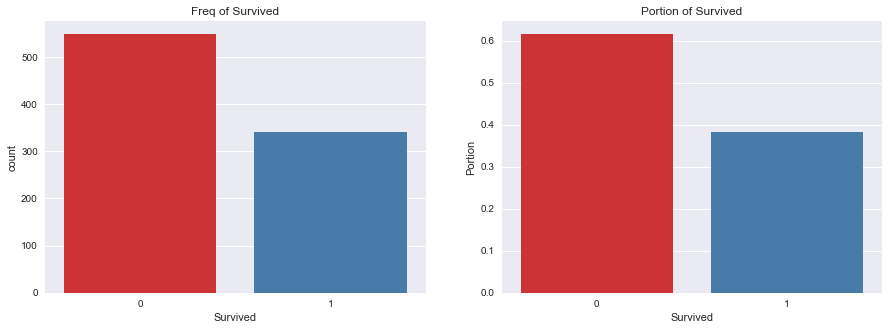

In [197]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.countplot('Survived', data = train)
plt.title('Freq of Survived')

plt.subplot(122)
sns.barplot(x = train.Survived.value_counts().index.values, y = train.Survived.value_counts()/train.shape[0])
plt.title('Portion of Survived')
plt.ylabel('Portion')
plt.xlabel('Survived')

### 결론 

사망 : 생존 = 6.5 : 3.5의 비율로 따로 샘플링을 적용할 필요가 없음을 발견했습니다.

## 전처리 #2 : 상관관계를 살펴보기 위해 범주형 변수들을 더미코딩.

변수들 하나하나 전부 살펴보는 것은 비효율 적이기 때문에 주로 pairplot이나 grid 플롯을 통해 숲을 본 후 유의해 보이는 변수들을 자세하게 살펴보는 과정을 거칩니다. 하지만 pair plot의 경우 숫자형이외의 값은 자동으로 생략하기 때문에 범주를 숫자로 바꿔주는 더미코딩 작업이 필요합니다. 이는 파이썬은 문자 데이터에 대해서 상관계수를 계산할 수 없기 때문입니다.

In [152]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [153]:
#생략하기로 했던 Name,Ticket,Cabin 을 제외한 범주형 변수 Pclass, Sex, Embarked 를 더미코딩합니다.

# Pclass
print('=============================================')
print(train.Pclass.value_counts())
print('=============================================')

# Sex
print('=============================================')
print(train.Sex.value_counts())
print('=============================================')

# Embarked
print('=============================================')
print(train.Embarked.value_counts())
print('=============================================')

3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
S    646
C    168
Q     77
Name: Embarked, dtype: int64


In [154]:
# Pclass
train.Pclass = train.Pclass.astype(np.int64)

# Sex
train.loc[train.Sex =='male', 'Sex'] = 0
train.loc[train.Sex =='female', 'Sex'] = 1
train.Sex = train.Sex.astype(np.int)

# Embarked
train.loc[train.Embarked =='S', 'Embarked'] = 0
train.loc[train.Embarked =='C', 'Embarked'] = 1
train.loc[train.Embarked =='Q', 'Embarked'] = 2
train.Embarked = train.Embarked.astype(np.int)

In [155]:
# Pclass
print('=============================================')
print(train.Pclass.value_counts())
print('=============================================')

# Sex
print('=============================================')
print(train.Sex.value_counts())
print('=============================================')

# Embarked
print('=============================================')
print(train.Embarked.value_counts())
print('=============================================')

3    491
1    216
2    184
Name: Pclass, dtype: int64
0    577
1    314
Name: Sex, dtype: int64
0    646
1    168
2     77
Name: Embarked, dtype: int64


### (3) 칼럼 특성과 분포 , 타겟 변수와의 관계 파악 계속
**step02 : 숲을 보는 EDA 타겟 변수와 모든 변수간 관계 + 변수들 간 상관관계 파악**

사망 : 생존 = 6.5 : 3.5의 비율이기 때문에 kde 플롯을 통해 비율로 분포를 살펴봅니다.

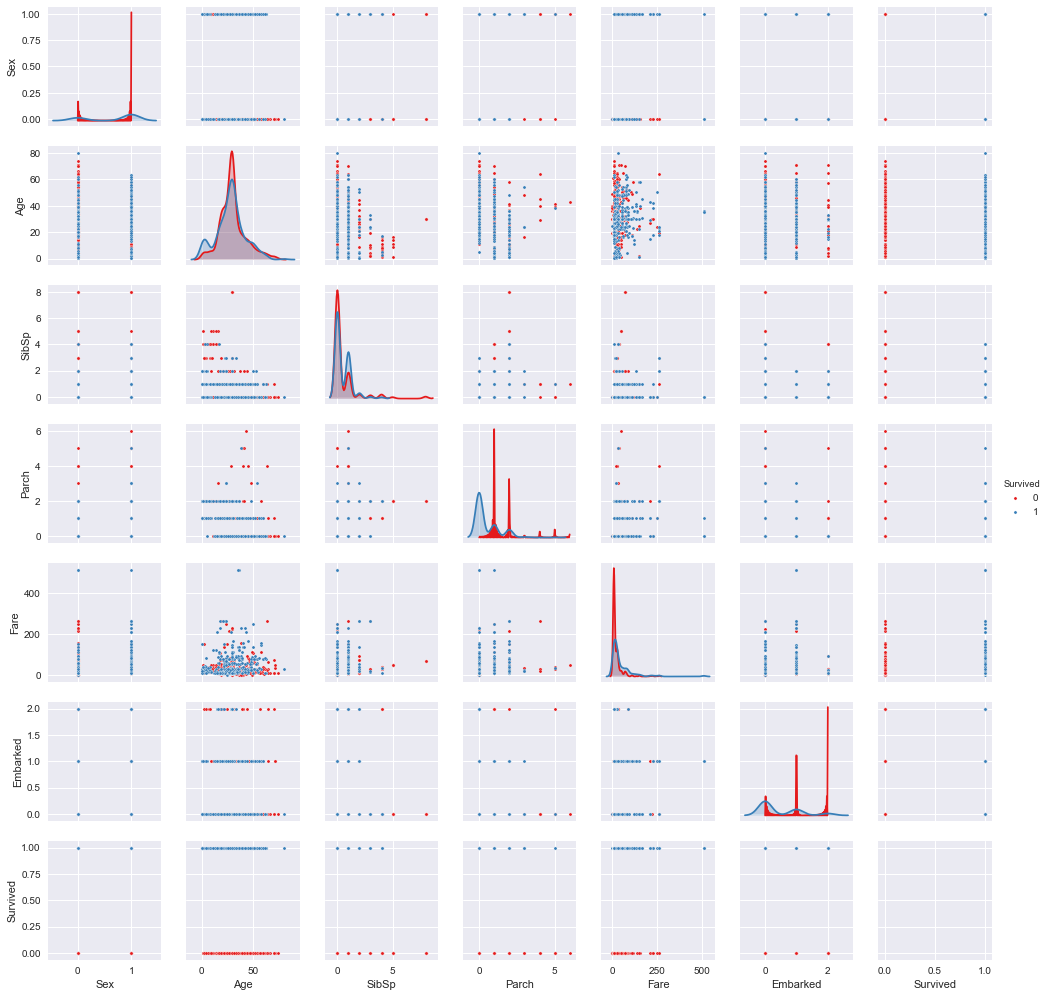

CPU times: user 7.41 s, sys: 120 ms, total: 7.53 s
Wall time: 7.61 s


In [198]:
%%time
g = sns.pairplot(train[['Sex','Age','SibSp','Parch','Fare','Embarked','Survived']], 
                 hue='Survived', 
                 size=2,
                 diag_kind = 'kde',
                 diag_kws=dict(shade=True),
                 plot_kws=dict(s=10) )

plt.show()

In [157]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 83.6+ KB


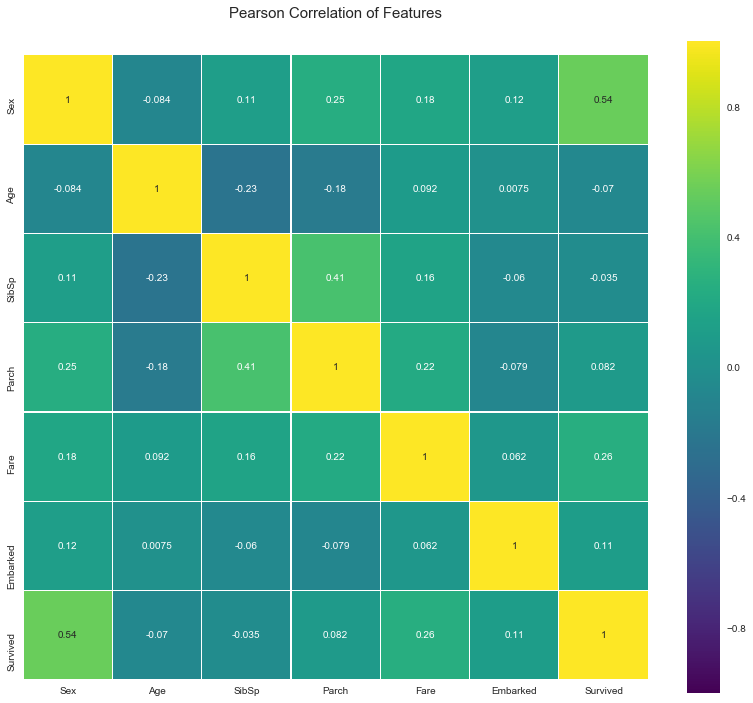

In [199]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))

plt.title('Pearson Correlation of Features', y=1.05, size=15)

sns.heatmap(train[['Sex','Age','SibSp','Parch','Fare','Embarked','Survived']].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white',
            annot=True)
plt.show()

### 결론 

Pair kdeplot에서 모든 변수에서 생존/사망 분포간 차이가 발견됐습니다. 하지만 피어슨 상관관계에서는 Sex와 Fare 변수를 제외하고 눈에띄는 차이가 발견되지 않았습니다. 이 경우 두 가지 가능성을 갖습니다.

1. 데이터에 노이즈가 많이 껴있는 등 혼재 돼 있다.(Feature engineering을 통해 해결가능)
2. 데이터가 생존과 사망을 분류하는데 좋지 않은 변수만 모여있다.(데이터 수집을 다시 설계해야 한다.)

이 경우 다른 데이터를 다시 수집할 수 없으니 1번의 선택지만 사용해야합니다.

또한 SibSp와 Parch의 경우 높은 상관성을 보입니다. 따라서 두 변수를 동시에 모델에 넣으면 좋지 않은 성능을 보여 줄 것이라는 예상을 할 수 있습니다.

### (4) 칼럼 특성과 분포 , 타겟 변수와의 관계 파악 계속
**step03 : 나무를 보는 EDA**

숲을 통해 데이터를 개괄적으로 이해했다면, 그 정보를 바탕으로 각 변수를 자세하게 살펴볼 차례입니다. 저는 보통 가장 범주형 변수와 연속형 변수로 나눈 후 살펴봅니다.

### 범주형 변수

1. Sex
2. Embarked
3. Pclass
4. SibSp
5. Parch
6. Cabin

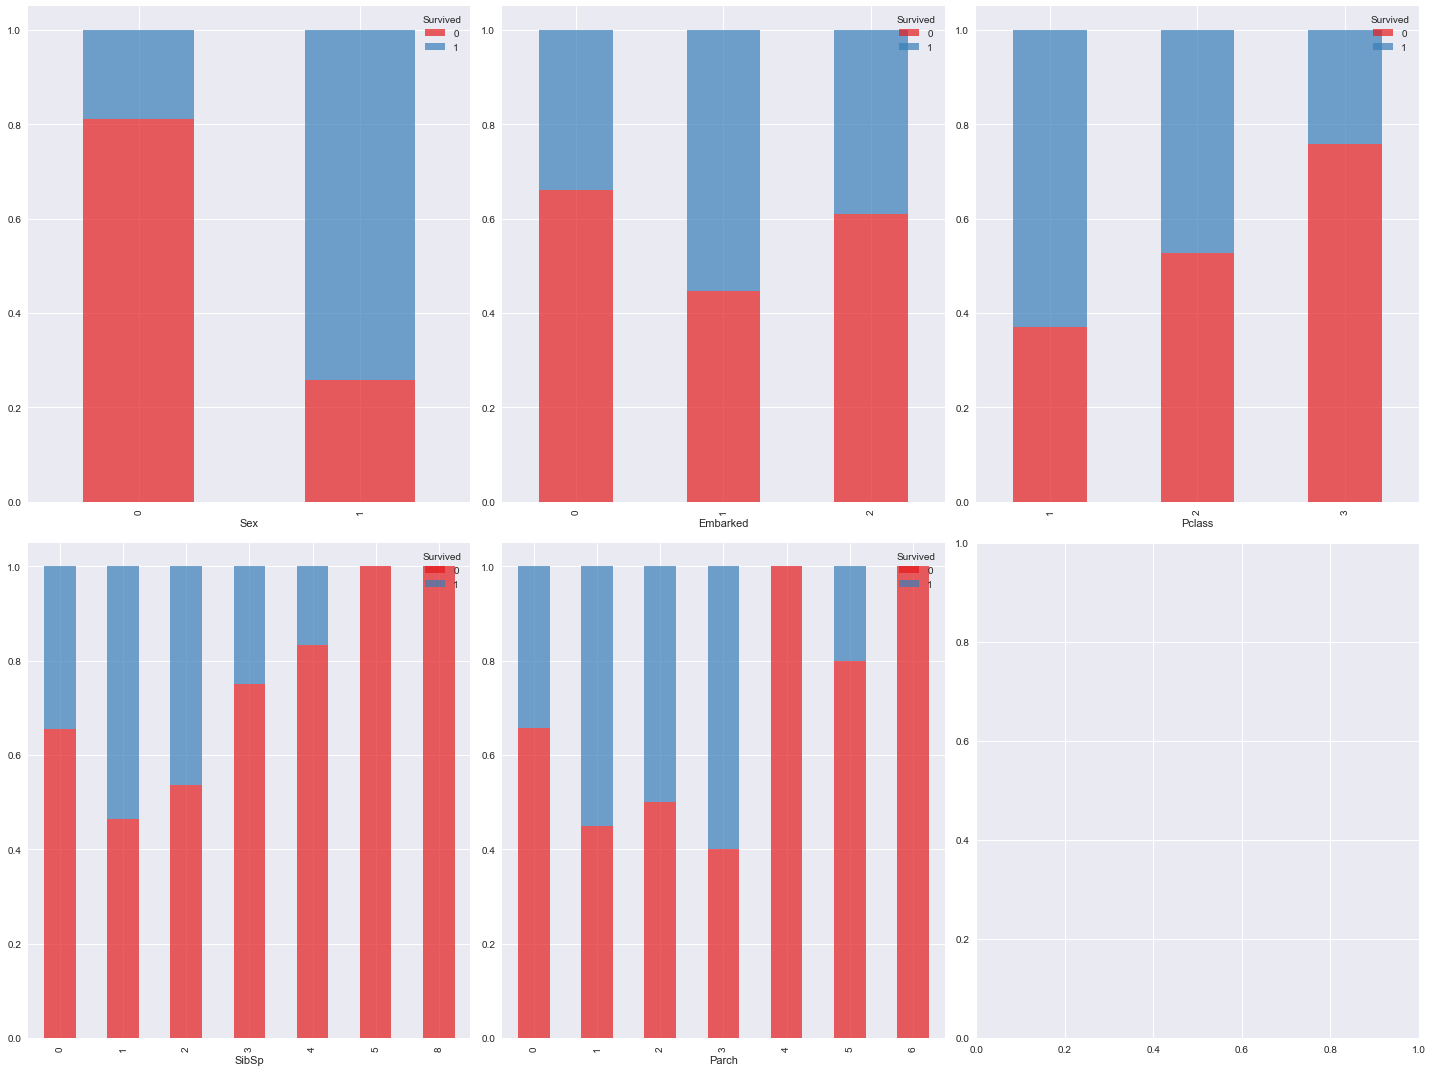

In [218]:
fig, ax = plt.subplots(2,3, figsize=(20,15))
pd.crosstab(train.Sex, train.Survived, normalize='index').plot(kind='bar', 
                                                               ax=ax[0,0], 
                                                               stacked=True,
                                                               alpha =0.7)

pd.crosstab(train.Embarked, train.Survived, normalize='index').plot(kind='bar', 
                                                                    ax=ax[0,1], 
                                                                    stacked=True,
                                                                    alpha =0.7)

pd.crosstab(train.Pclass, train.Survived, normalize='index').plot(kind='bar', 
                                                                  ax=ax[0,2], 
                                                                  stacked=True,
                                                                  alpha =0.7)

pd.crosstab(train.SibSp, train.Survived, normalize='index').plot(kind='bar', 
                                                                 ax=ax[1,0], 
                                                                 stacked=True,
                                                                 alpha =0.7)

pd.crosstab(train.Parch, train.Survived, normalize='index').plot(kind='bar', 
                                                                 ax=ax[1,1], 
                                                                 stacked=True,
                                                                 alpha =0.7)

plt.tight_layout()
plt.show()

### Cabin 변수

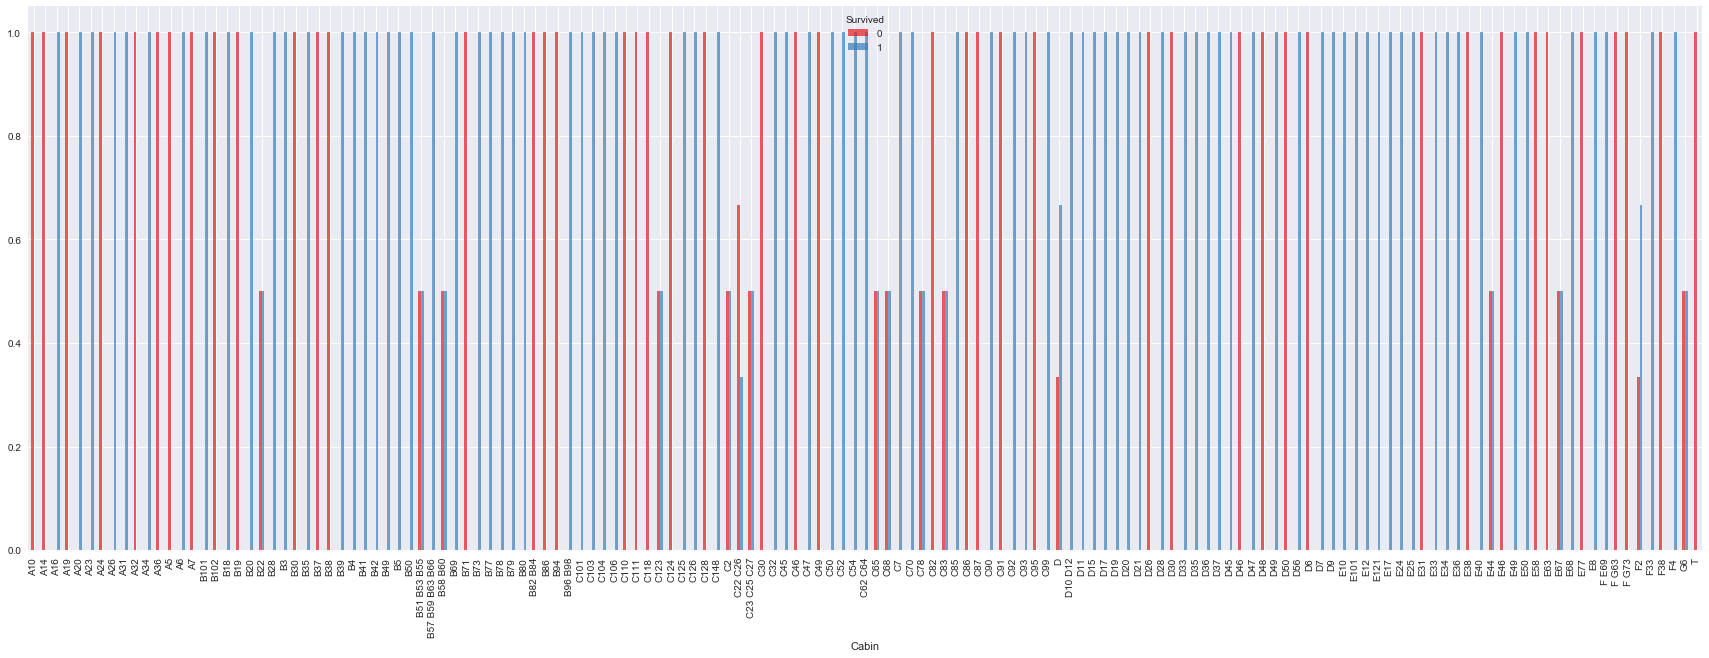

In [229]:
# 결측치 제외 후 살펴본다.
fig, ax = plt.subplots(1,1,figsize=(30,10))
pd.crosstab(train.Cabin.dropna(), train.Survived, normalize='index').plot(kind='bar',
                                                                          ax=ax,
                                                                          alpha =0.7)
plt.show()

In [234]:
# 결측값의 특성을 보기 위해 문자열 'NaN' 으로 값을 변환
train.Cabin[train.Cabin.isnull()] = 'NaN'

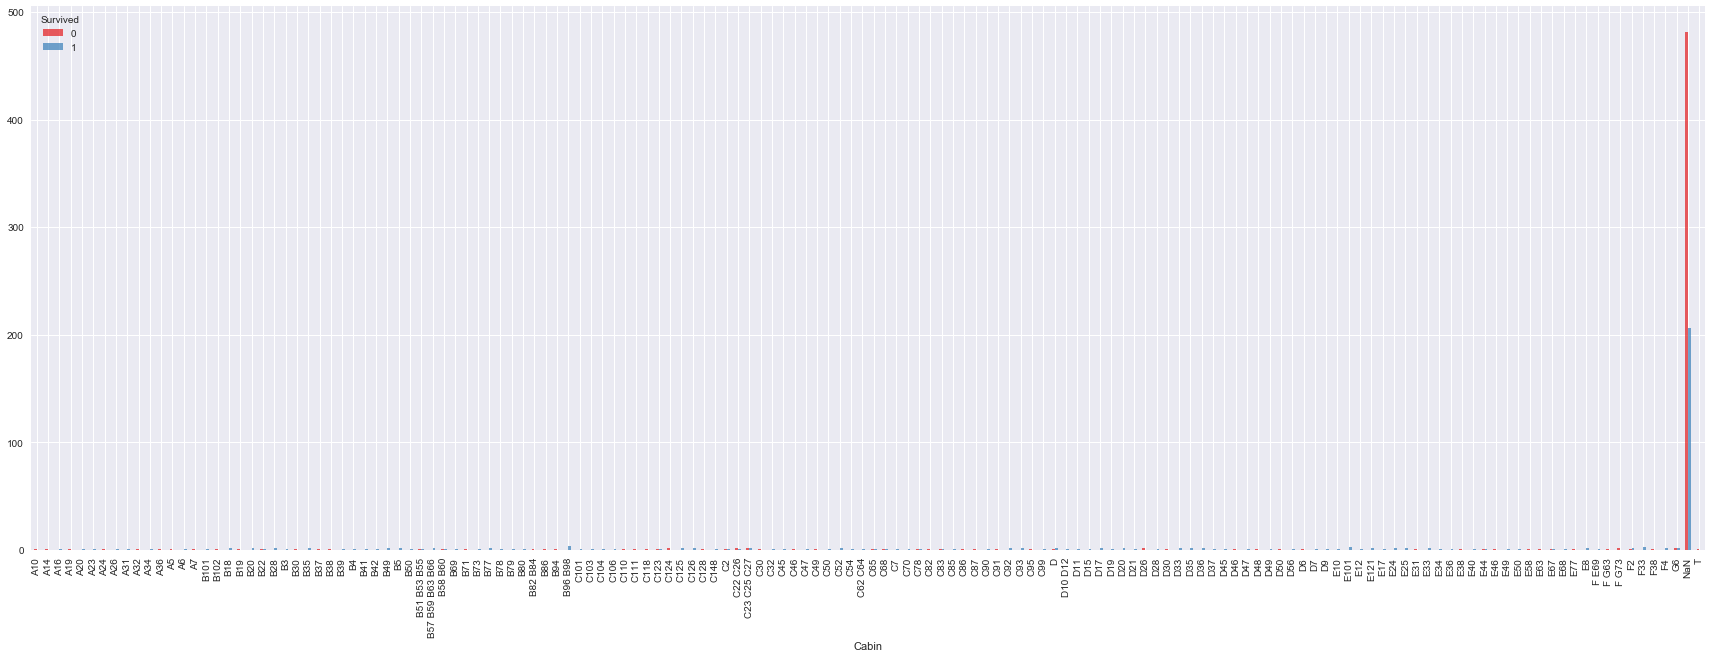

In [236]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
pd.crosstab(train.Cabin, train.Survived).plot(kind='bar',ax=ax,alpha =0.7)
plt.show()

### 연속형 변수

In [238]:
def vis_diff(df, col):
    yes = df.loc[df.Survived==1].dropna()
    no = df.loc[df.Survived==0].dropna()
    fig, (ax1, ax2) = plt.subplots(
                               1,2, 
                               figsize=(15, 5),
                               facecolor='w', 
                               edgecolor='k'
                              )

    sns.distplot(yes[col], ax=ax1, color='blue',  label='Survived YES')
    sns.distplot(no[col], ax=ax1, color='red', label='Survived NO')
    ax1.legend()
    ax1.set(title='PDF of Survived')

    N = yes[col].shape[0]
    X2 = np.sort(yes[col])
    F2 = np.array(range(N))/float(N)

    yes_plot = ax2.plot(X2, F2, alpha=0.8, color='blue', label='Survived YES')

    ax2.set(title="CDF of Survived")

    N = no[col].shape[0]
    X2 = np.sort(no[col])
    F2 = np.array(range(N))/float(N)

    no_plot = ax2.plot(X2, F2, alpha=0.8, color='red', label='Survived NO')
    ax2.legend()

    fig.tight_layout()
    plt.show()

### Age 변수

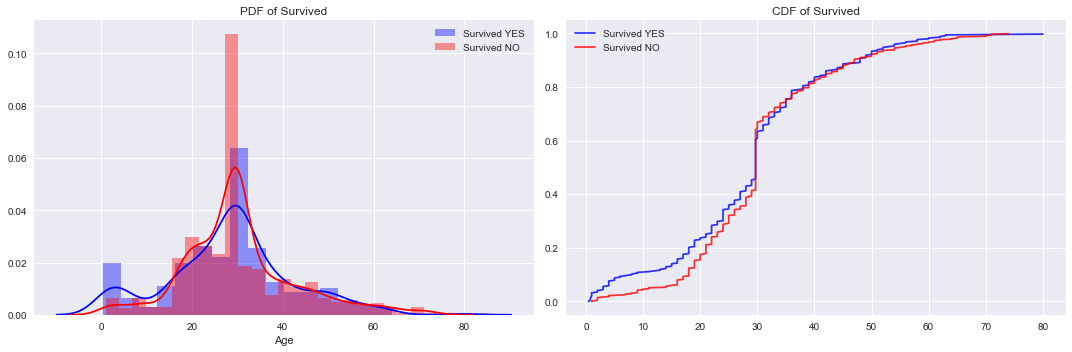

In [239]:
vis_diff(train, 'Age')

In [250]:
# 나이 소수점을 버리고 Int형으로 변환
train.Age = round(train.Age).astype(np.int)

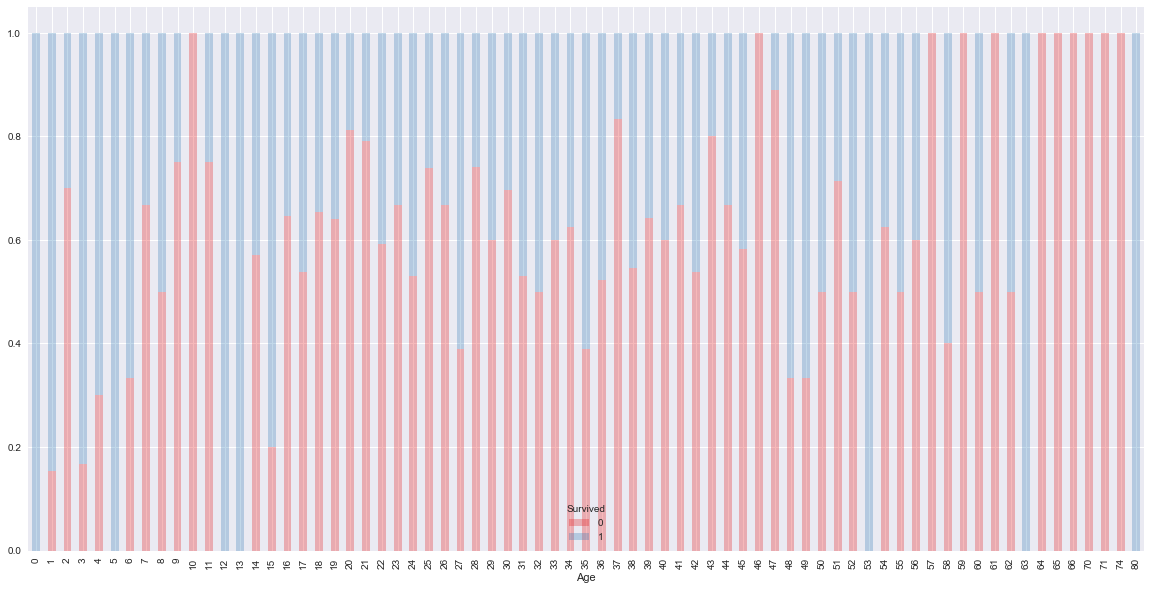

In [261]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
pd.crosstab(train.Age, train.Survived, normalize='index').plot(kind='bar', 
                                                               stacked=True,
                                                               ax=ax,
                                                               alpha =0.3)
plt.show()

### Fare 변수

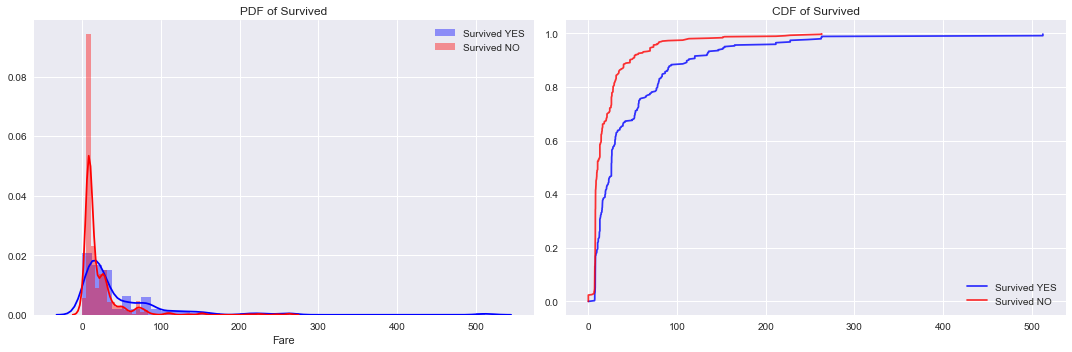

In [258]:
vis_diff(train, 'Fare')

In [260]:
train.Fare = round(train.Fare)

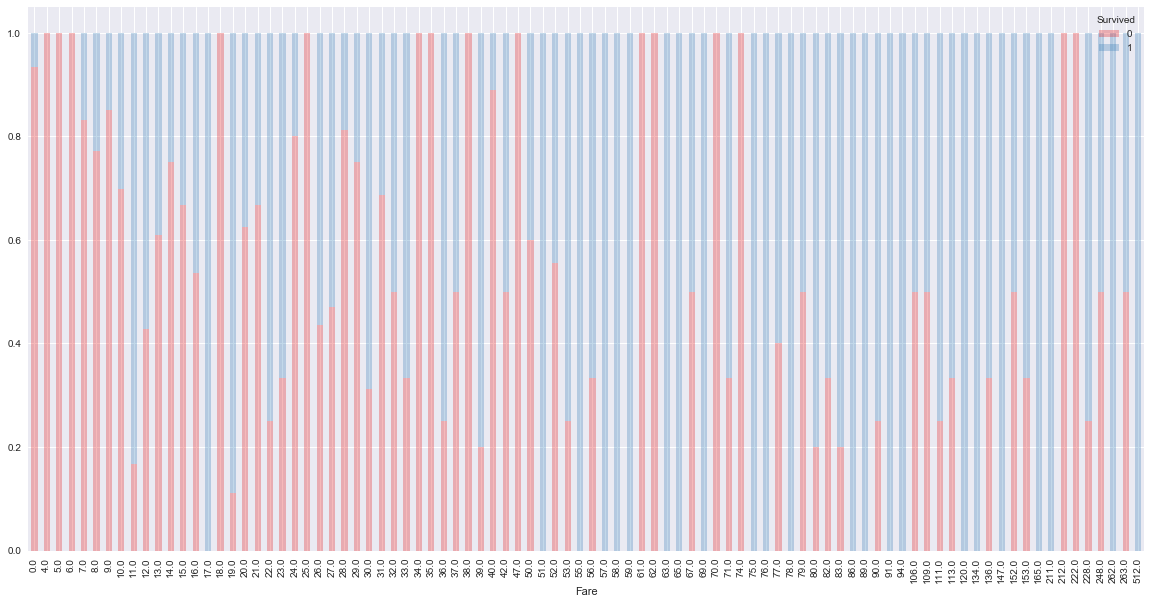

In [262]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
pd.crosstab(train.Fare, train.Survived, normalize='index').plot(kind='bar', 
                                                               stacked=True,
                                                               ax=ax,
                                                               alpha =0.3)
plt.show()